<a href="https://colab.research.google.com/github/Toon-nooT/notebooks/blob/main/Signature_Detection_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import cv2
import numpy as np
import time
import math

def find_signature_bounding_boxes(image):
    # Start measuring time
    start_time = time.time()

    if image is None:
        raise ValueError("Could not open or find the image")

    # Binarize the image using Otsu's thresholding method
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Threshold the image using Otsu's method
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8, ltype=cv2.CV_32S)

    # Calculate median area of components
    areas = stats[1:, cv2.CC_STAT_AREA]  # Exclude background
    median_area = np.median(areas)
    print('median_area: ' + str(median_area))
    median_character_width = int(math.sqrt(median_area))
    print('median_character_width: ' + str(median_character_width))

    # Define area thresholds
    min_area_threshold = median_area * 4
    max_area_threshold = median_area * 50

    # Filter components based on area thresholds
    possible_signatures = []
    for i in range(1, num_labels):  # Exclude background
        area = stats[i, cv2.CC_STAT_AREA]
        if min_area_threshold < area < max_area_threshold:
            left = stats[i, cv2.CC_STAT_LEFT]
            top = stats[i, cv2.CC_STAT_TOP]
            width = stats[i, cv2.CC_STAT_WIDTH]
            height = stats[i, cv2.CC_STAT_HEIGHT]
            print('Found candidate with area: ' + str(area))
            #filter horizontal lines
            if height < median_character_width * 5 and width > median_character_width*30:
              print('   -> candidate is horizontal line with width, height: ' + str(width) + ',' + str(height))
              continue
            #filter vertical lines
            if width < median_character_width * 5 and height > median_character_width*30:
              print('   -> candidate is vertical line with width, height: ' + str(width) + ',' + str(height))
              continue
            #filter on a ratio of black pixels (logos for example have a higher ratio)for now guestimate is 0.3
            roi = binary_image[top:top+height, left:left+width]
            num_black_pixels = cv2.countNonZero(roi) # Calculate the number of black pixels in the ROI
            total_pixels = width * height # Calculate the total number of pixels in the ROI
            ratio = num_black_pixels / total_pixels # Calculate and return the ratio of black pixels
            print('   -> candidate has black pixel ratio: ' + str(ratio))
            if ratio > 0.30:
              print('   -> candidate has too high black pixel ratio: ' )
              continue
            possible_signatures.append((left, top, width, height))

    print('Nr of signatures found before merging: ' + str(len(possible_signatures)))
    possible_signatures = merge_nearby_rectangles(possible_signatures, nearness=median_character_width*4)

    # End measuring time
    end_time = time.time()
    print(f"Function took {end_time - start_time:.2f} seconds to process the image.")

    return possible_signatures

#To merge rectangles that are near each other, we can define a function that takes in the list of bounding boxes and a tolerance value (which determines how close rectangles need to be to be considered "near" each other). We can then iterate through the list of rectangles, and for each rectangle, check if there is any other rectangle that overlaps with it by more than the tolerance value. If we find such a rectangle, we can merge them by taking the union of their bounding boxes, and removing the original rectangles from the list.
def merge_nearby_rectangles(rectangles, nearness):
    def is_near(rect1, rect2):
        left1, top1, width1, height1 = rect1
        left2, top2, width2, height2 = rect2
        right1, bottom1 = left1 + width1, top1 + height1
        right2, bottom2 = left2 + width2, top2 + height2
        return not (right1 < left2 - nearness or left1 > right2 + nearness or
                    bottom1 < top2 - nearness or top1 > bottom2 + nearness)

    def merge(rect1, rect2):
        left1, top1, width1, height1 = rect1
        left2, top2, width2, height2 = rect2
        right1, bottom1 = left1 + width1, top1 + height1
        right2, bottom2 = left2 + width2, top2 + height2
        min_left = min(left1, left2)
        min_top = min(top1, top2)
        max_right = max(right1, right2)
        max_bottom = max(bottom1, bottom2)
        return (min_left, min_top, max_right - min_left, max_bottom - min_top)

    merged = []
    while rectangles:
        current = rectangles.pop(0)
        has_merged = False

        for i, other in enumerate(merged):
            if is_near(current, other):
                merged[i] = merge(current, other)
                has_merged = True
                break

        if not has_merged:
            for i in range(len(rectangles) - 1, -1, -1):
                if is_near(current, rectangles[i]):
                    current = merge(current, rectangles.pop(i))

        if not has_merged:
            merged.append(current)

    return merged


In [ ]:
!wget 'https://d2skn5554g4boz.cloudfront.net/2020-website/658/3470213/large/3470213_2.jpg'


median_area: 59.0
median_character_width: 7
Found candidate with area: 2523
   -> candidate is vertical line with width, height: 7,647
Found candidate with area: 419
   -> candidate has black pixel ratio: 0.0863408921537315
Found candidate with area: 2923
   -> candidate has black pixel ratio: 0.520109439124487
   -> candidate has too high black pixel ratio: 
Found candidate with area: 478
   -> candidate has black pixel ratio: 0.45068027210884354
   -> candidate has too high black pixel ratio: 
Found candidate with area: 298
   -> candidate has black pixel ratio: 0.7883597883597884
   -> candidate has too high black pixel ratio: 
Found candidate with area: 299
   -> candidate has black pixel ratio: 0.791005291005291
   -> candidate has too high black pixel ratio: 
Found candidate with area: 277
   -> candidate has black pixel ratio: 0.38472222222222224
   -> candidate has too high black pixel ratio: 
Found candidate with area: 333
   -> candidate has black pixel ratio: 0.3778280542986

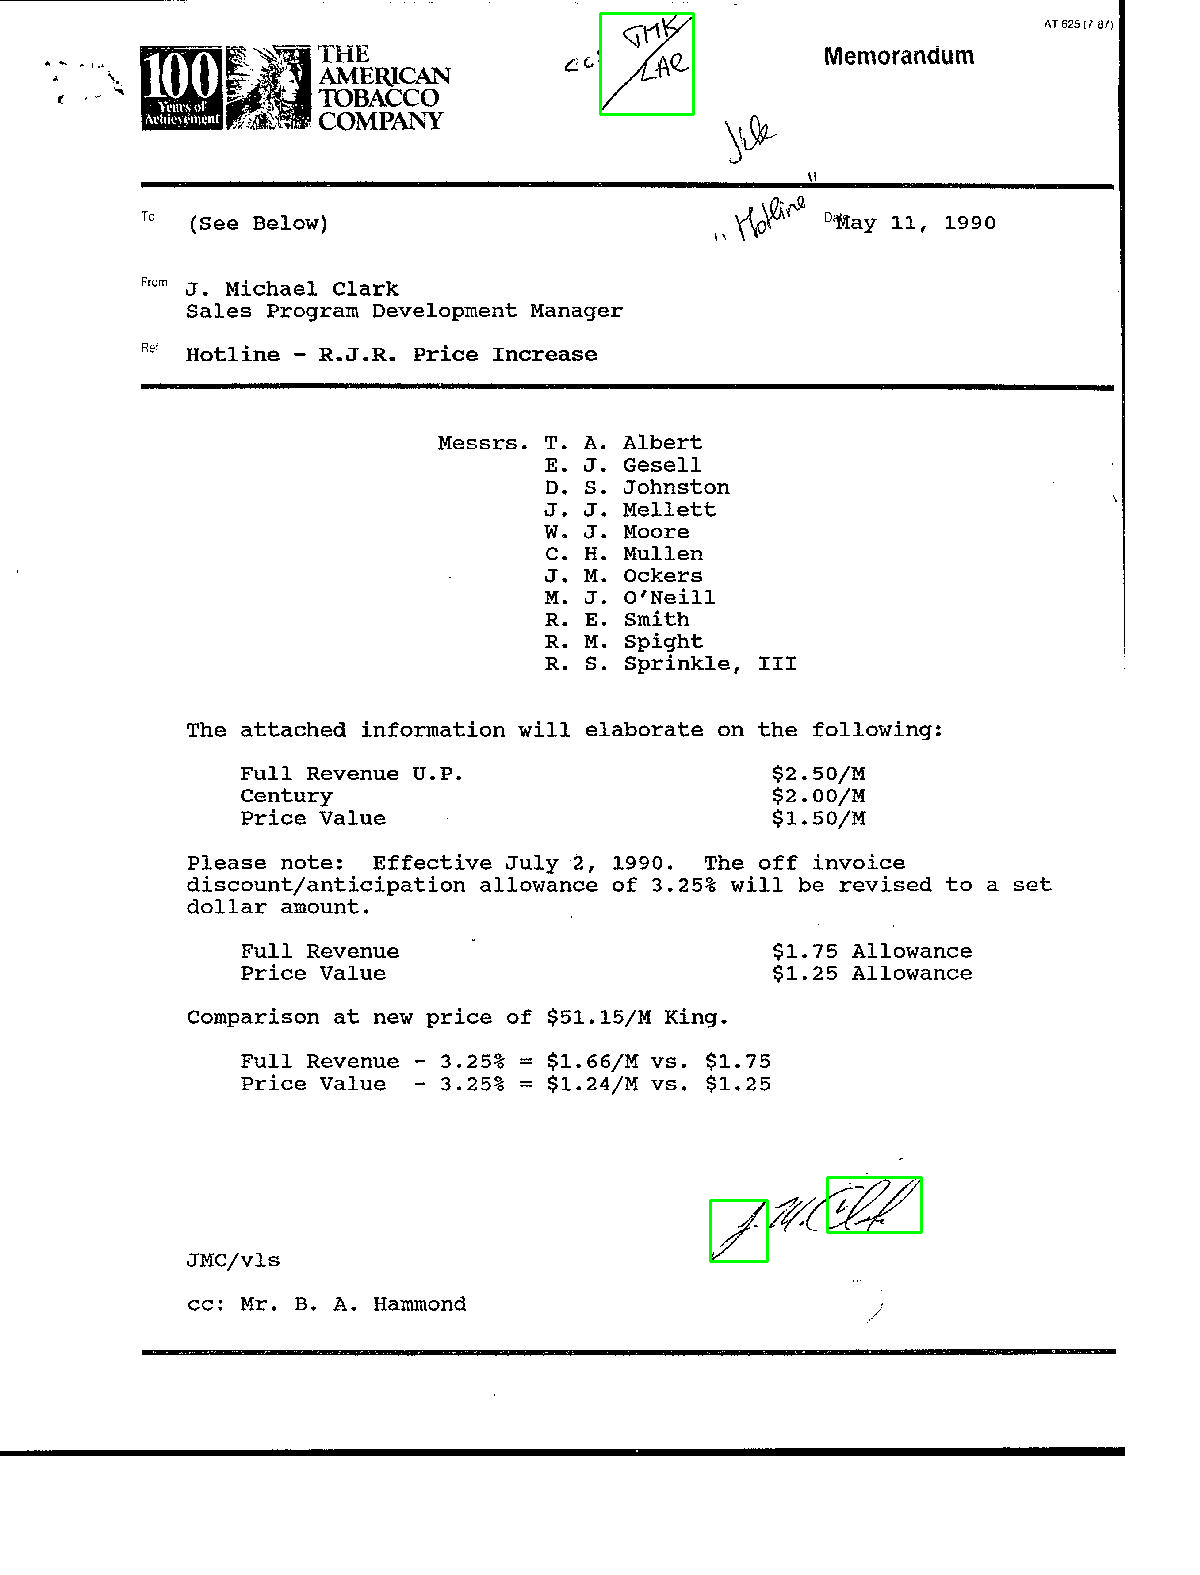

In [52]:
import cv2
from google.colab.patches import cv2_imshow

# Read the image
image = cv2.imread('3470213_2.jpg')

# Find bounding boxes of possible signatures on the document
signatures = find_signature_bounding_boxes(image)
print('Nr of signatures found: ' + str(len(signatures)))
# Draw bounding boxes on the image
for (x, y, w, h) in signatures:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Show the image with bounding boxes
cv2_imshow( image)
cv2.waitKey(0)
cv2.destroyAllWindows()